In [1]:
import os
os.chdir('/content/drive/MyDrive/CAMemBERT2')
import glob
import json
import pdb
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
plt.ioff()

In [34]:
tasks = ['aes','ged','ner']
global tasks
best_metrics_for_task = {'aes':'pearson_aes','ged':'f_0_5_ged','ner':'f1_score_macro_ner'}
global best_metrics_for_task

def create_loss_plot(data,model):
    try:
        train_loss,train_steps,eval_loss,eval_steps = data['train']['loss'],data['train']['step'],data['eval']['total_loss'], data['eval']['step']
    except:
        print(f'missing loss data for {model}')
        return
    train_loss,train_steps,eval_loss,eval_steps = [[round(val, 1) for val in metric] for metric in [train_loss,train_steps,eval_loss,eval_steps]]
    fig= plt.figure()
    plt.plot(train_steps,train_loss,'r',label='train')
    plt.plot(eval_steps,eval_loss,'b',label='eval')
    plt.legend(loc="upper right")
    plt.title(f'Loss vs Steps : {model}')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    fig.savefig(f'/content/drive/MyDrive/CAMemBERT2/results/plots/losses/{model.replace(".","")}')
    plt.close()

def create_test_pred_plot(data,model):
    try:
        preds,labels = data['preds'],data['labels']
    except:
        print(f'missing loss data for {model}')
        return
    preds,labels = [[round(val, 1) for val in metric] for metric in [preds,labels]]
    fig= plt.figure()
    plt.scatter(preds,labels)
    plt.title(f'Predicted vs Acutal Scores : {model}')
    plt.xlabel('Predicted Score')
    plt.ylabel('Acutal Score')
    plt.savefig(f'/content/drive/MyDrive/CAMemBERT2/results/plots/predictions/{model.replace(".","")}')
    plt.close()

def append_model_details(task_dict,set_type,task,model,data):
    task_dict[set_type][task]['model'].append(model)
    task_dict[set_type][task]['learning_rate'].append(data['info']['learning_rate'])
    task_dict[set_type][task]['batch_size'].append(data['info']['batch_size'])
    task_dict[set_type][task]['pretrained_model'].append(data['info']['pretrained_model'])
    task_dict[set_type][task]['frozen_layers'].append(data['info']['frozen_layers'])
    task_dict[set_type][task]['normalised_values'].append(data['info']['normalised_values'])
    task_dict[set_type][task]['epochs'].append(round(max(data['eval']['epoch'])))
    task_dict[set_type][task]['runtime'].append(data['info']['runtime'])
    task_dict[set_type][task]['secs_per_epoch'].append(data['info']['runtime']/len(data['eval']['epoch']))
    task_dict[set_type][task]['n_shared_layers'].append(data['info']['shared_encoder_n_layers'])
    task_dict[set_type][task]['position'].append(data['info']['output_layer_by_task'][task])
    task_dict[set_type][task]['task_priorites'].append(data['info']['task_priorities_priority_as_key'])
    task_dict[set_type][task]['init_task_weightings'].append(data['info']['init_task_weightings'])
    if data['info']['early_stopping_metric'] != 'loss':
        primary_task = data['info']['task_priorities_priority_as_key']['primary_task']
        task_dict[set_type][task]['early_stopping_metric'].append(best_metrics_for_task[primary_task])
    else:
        task_dict[set_type][task]['early_stopping_metric'].append('loss')

    if task=='aes':
        task_dict[set_type][task]['scoring'].append(data['info']['scoring'])
    return task_dict

def update_task_dict(task,task_dict,data):
    [task_dict['eval'][task][metric_name].append(value) for metric_name,value in data['best'][task].items() if 'weight_coef' not in metric_name]
    task_dict = append_model_details(task_dict,'eval',task,model,data)
    test_metrics_for_task = {metric_name:value for metric_name,value in data['test'].items() if task in metric_name}
    [task_dict['test'][task][metric_name].append(value) for metric_name,value in test_metrics_for_task.items() if 'weight_coef' not in metric_name]
    task_dict = append_model_details(task_dict,'test',task,model,data)
    return task_dict

def create_result_csvs(task_dict):
    dfs_set_type = {}
    for set_type,dicts in task_dict.items():
        dfs_set_type[set_type] = {}
        for task,metrics in dicts.items():
            df = pd.DataFrame(metrics).sort_values(by = best_metrics_for_task[task],ascending=False)
            df['frozen_layers'] = df['frozen_layers'].fillna(0)
            print(set_type,task,'\n',df)
            df.to_csv(f'/content/drive/MyDrive/CAMemBERT2/results/{set_type}_results/{task}.csv')
            dfs_set_type[set_type][task] = df
    return dfs_set_type

task_dict = {'eval':defaultdict(lambda: defaultdict(list)),'test':defaultdict(lambda: defaultdict(list))}
for fp in glob.glob('/content/drive/MyDrive/CAMemBERT2/results/raw_results/*.json'):
    with open(fp) as json_file:
        data = json.load(json_file)
    model = fp.split('/')[-1].replace('.json','')
    create_loss_plot(data,model)
    try:
        data['preds']
        create_test_pred_plot(data['preds']['aes'],model)
    except:
        pass
    for task in tasks:
        if task in data['info']['tasks']:
            task_dict = update_task_dict(task,task_dict,data)

dfs = create_result_csvs(task_dict)


missing loss data for 1630760512
missing loss data for 1630763494
missing loss data for 1630763624
eval aes 
     rmse_aes  pearson_aes  ...  early_stopping_metric  scoring
0   6.191051     0.723195  ...            pearson_aes   script
3   5.741256     0.699714  ...            pearson_aes   script
12  7.338067     0.687928  ...            pearson_aes   script
4   4.297482     0.682024  ...            pearson_aes   script
1   4.297482     0.682024  ...            pearson_aes   script
10  6.191392     0.681187  ...            pearson_aes   script
37  6.092120     0.678535  ...            pearson_aes   script
27  4.284987     0.678513  ...            pearson_aes   script
38  5.485308     0.677824  ...            pearson_aes   script
35  5.485308     0.677824  ...            pearson_aes   script
29  6.107827     0.675357  ...                   loss   script
8   5.385165     0.674753  ...            pearson_aes   script
33  4.949747     0.672013  ...                   loss   script
32  4.94

In [35]:
dfs['test']['aes']

,rmse_aes,pearson_aes,spearman_aes,kappa_aes,aes,model,learning_rate,batch_size,pretrained_model,frozen_layers,normalised_values,epochs,runtime,secs_per_epoch,n_shared_layers,position,task_priorites,init_task_weightings,early_stopping_metric,scoring
30,5.440014,0.813462,0.806078,0.586979,0.005307,1630834286,0.00004,8,distilroberta-base,0.0,"[40, 0]",6,407.757323,67.959554,0,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss,script
31,5.440014,0.813462,0.806078,0.586979,0.005307,1630834696,0.00004,8,distilroberta-base,0.0,"[40, 0]",6,407.543310,67.923885,0,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss,script
32,5.440014,0.813462,0.806078,0.586979,0.005307,1630835105,0.00004,8,distilroberta-base,0.0,"[40, 0]",6,407.498310,67.916385,0,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss,script
33,5.440014,0.813462,0.806078,0.586979,0.005307,1630835515,0.00004,8,distilroberta-base,0.0,"[40, 0]",6,407.566059,67.927677,0,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss,script
29,4.273221,0.806241,0.793747,0.701721,0.003295,1630833876,0.00004,8,distilroberta-base,0.0,"[40, 0]",6,407.425578,67.904263,0,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss,script
0,5.115168,0.798963,0.804942,0.650108,0.016795,1630758066,0.00001,8,distilroberta-base,0.0,"[40, 0]",8,258.907881,32.363485,0,-1,{'primary_task': 'aes'},"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",pearson_aes,script
17,4.373214,0.797296,0.791712,0.679756,0.003366,1630772236,0.00004,8,distilroberta-base,0.0,"[40, 0]",8,702.113476,87.764184,2,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",pearson_aes,script
45,6.170265,0.790173,0.787494,0.510227,0.024592,1630841902,0.00008,8,distilroberta-base,0.0,"[40, 0]",4,152.105055,38.026264,1,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss,script
46,6.170265,0.790173,0.787494,0.510227,0.024592,1630842057,0.00008,8,distilroberta-base,0.0,"[40, 0]",4,152.191837,38.047959,1,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss,script
48,6.170265,0.790173,0.787494,0.510227,0.024592,1630842367,0.00008,8,distilroberta-base,0.0,"[40, 0]",4,152.261730,38.065433,1,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss,script


In [36]:
dfs['test']['ged']

,accuracy_ged,f1_score_macro_ged,f1_score_weighted_ged,f_0_5_ged,ged,model,learning_rate,batch_size,pretrained_model,frozen_layers,normalised_values,epochs,runtime,secs_per_epoch,n_shared_layers,position,task_priorites,init_task_weightings,early_stopping_metric
36,0.826212,0.721166,0.840453,0.631674,0.158722,1630837337,0.00004,8,distilroberta-base,0.0,"[40, 0]",5,339.567977,67.913595,0,-1,"{'primary_task': 'ged', 'aux_task': 'ner'}","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss
21,0.813975,0.710003,0.831030,0.628708,0.153593,1630773694,0.00008,8,distilroberta-base,0.0,"[40, 0]",4,270.488224,67.622056,0,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",pearson_aes
38,0.832064,0.724634,0.844514,0.624940,0.163420,1630837953,0.00004,8,distilroberta-base,0.0,"[40, 0]",5,339.340165,67.868033,0,-1,"{'primary_task': 'ged', 'aux_task': 'ner'}","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss
40,0.832064,0.724634,0.844514,0.624940,0.163420,1630838568,0.00004,8,distilroberta-base,0.0,"[40, 0]",5,339.635486,67.927097,0,-1,"{'primary_task': 'ged', 'aux_task': 'ner'}","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss
41,0.829742,0.721930,0.842966,0.624642,0.642195,1630841747,0.00008,8,distilroberta-base,0.0,"[40, 0]",4,151.899318,37.974829,1,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss
39,0.836553,0.726130,0.847338,0.614913,0.159641,1630838227,0.00004,8,distilroberta-base,0.0,"[40, 0]",4,271.875839,67.968960,0,-1,"{'primary_task': 'ged', 'aux_task': 'ner'}","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss
37,0.836553,0.726130,0.847338,0.614913,0.159641,1630837611,0.00004,8,distilroberta-base,0.0,"[40, 0]",4,272.364117,68.091029,0,-1,"{'primary_task': 'ged', 'aux_task': 'ner'}","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss
18,0.844863,0.733368,0.853543,0.613382,0.176979,1630771990,0.00004,8,distilroberta-base,0.0,"[40, 0]",6,245.185335,40.864222,0,-1,"{'primary_task': 'ged', 'aux_task': 'ner'}","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",f_0_5_ged
24,0.841844,0.729255,0.850945,0.608231,0.122486,1630777715,0.00004,8,distilroberta-base,0.0,"[40, 0]",3,204.610076,68.203359,0,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 0.30000000000000004, 'ged': 0.7, 'ner'...",pearson_aes
31,0.842031,0.729239,0.851043,0.607497,0.172831,1630833876,0.00004,8,distilroberta-base,0.0,"[40, 0]",6,407.425578,67.904263,0,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss


In [37]:
dfs['test']['ner']

,accuracy_ner,f1_score_macro_ner,f1_score_weighted_ner,ner,model,learning_rate,batch_size,pretrained_model,frozen_layers,normalised_values,epochs,runtime,secs_per_epoch,n_shared_layers,position,task_priorites,init_task_weightings,early_stopping_metric
49,0.983504,0.906591,0.983681,0.063611,1630844323,0.00008,8,distilroberta-base,0.0,"[40, 0]",5,364.884486,72.976897,1,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss
42,0.983547,0.904325,0.983948,0.102906,1630839305,0.00008,8,distilroberta-base,0.0,"[40, 0]",9,313.250574,34.805619,0,-1,{'primary_task': 'ner'},"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss
21,0.982879,0.904095,0.983107,0.062906,1630773694,0.00008,8,distilroberta-base,0.0,"[40, 0]",4,270.488224,67.622056,0,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",pearson_aes
41,0.983332,0.902820,0.983552,0.093479,1630838990,0.00008,8,distilroberta-base,0.0,"[40, 0]",6,209.985182,34.997530,0,-1,{'primary_task': 'ner'},"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss
47,0.983224,0.902070,0.983565,0.074054,1630843515,0.00008,8,distilroberta-base,0.0,"[40, 0]",10,725.468699,72.546870,1,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss
50,0.983224,0.902070,0.983565,0.074054,1630845052,0.00008,8,distilroberta-base,0.0,"[40, 0]",10,726.112323,72.611232,1,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss
2,0.982815,0.899692,0.983235,0.102249,1630762602,0.00008,8,distilroberta-base,0.0,"[40, 0]",8,277.414044,34.676755,0,-1,{'primary_task': 'ner'},"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",f1_score_macro_ner
5,0.982815,0.899692,0.983235,0.102249,1630763444,0.00008,8,distilroberta-base,3.0,"[40, 0]",8,277.561677,34.695210,0,-1,{'primary_task': 'ner'},"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",f1_score_macro_ner
48,0.981759,0.898547,0.982154,0.074588,1630843955,0.00008,8,distilroberta-base,0.0,"[40, 0]",6,436.629833,72.771639,1,-1,"{'primary_task': 'aes', 'secondary_task': 'ged...","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss
38,0.982858,0.898364,0.983257,0.066801,1630837953,0.00004,8,distilroberta-base,0.0,"[40, 0]",5,339.340165,67.868033,0,-1,"{'primary_task': 'ged', 'aux_task': 'ner'}","{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",loss


Text(0, 0.5, 'performance metric')

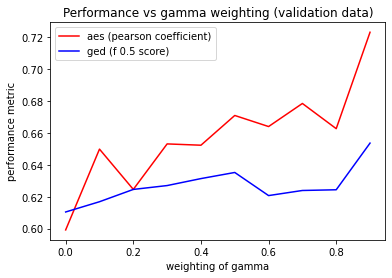

In [54]:
dfaes_eval = dfs['eval']['aes'].copy()
dfged_eval = dfs['eval']['ged'].copy()
dfaes_eval['init_task_weightings'] = dfaes_eval['init_task_weightings'].apply(lambda x : x['aes'])
dfged_eval['init_task_weightings'] = dfged_eval['init_task_weightings'].apply(lambda x : x['ged'])

aes_values = dfaes_eval.groupby('init_task_weightings')['pearson_aes'].max().values
ged_values = dfged_eval.groupby('init_task_weightings')['f_0_5_ged'].max().values

plt.plot([x*0.1 for x in range(0,10)],aes_values,'r',label='aes (pearson coefficient)')
plt.plot([x*0.1 for x in range(0,10)], ged_values,'b',label='ged (f 0.5 score)')
plt.legend(loc="upper left")
plt.title(f'Performance vs gamma weighting (validation data)')
plt.xlabel('weighting of gamma')
plt.ylabel('performance metric')


Text(0, 0.5, 'performance metric')

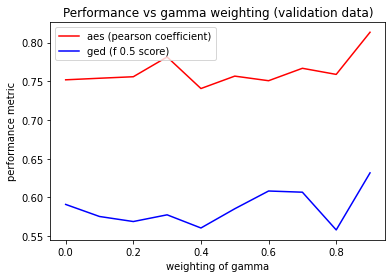

In [55]:
dfaes_test = dfs['test']['aes'].copy()
dfged_test = dfs['test']['ged'].copy()
dfaes_test['init_task_weightings'] = dfaes_test['init_task_weightings'].apply(lambda x : x['aes'])
dfged_test['init_task_weightings'] = dfged_test['init_task_weightings'].apply(lambda x : x['ged'])

aes_values = dfaes_test.groupby('init_task_weightings')['pearson_aes'].max().values
ged_values = dfged_test.groupby('init_task_weightings')['f_0_5_ged'].max().values

plt.plot([x*0.1 for x in range(0,10)],aes_values,'r',label='aes (pearson coefficient)')
plt.plot([x*0.1 for x in range(0,10)], ged_values,'b',label='ged (f 0.5 score)')
plt.legend(loc="upper left")
plt.title(f'Performance vs gamma weighting (validation data)')
plt.xlabel('weighting of gamma')
plt.ylabel('performance metric')

In [49]:
def perform_groupby(df,metrics,additional_groups=['learning_rate',
                                    'n_shared_layers','frozen_layers',
                                    'position','early_stopping_metric',
                                    'init_task_weightings',]):
    df = df.fillna(0)
    df.task_priorites = df.task_priorites.apply(lambda x : str(x))
    df.init_task_weightings = df.init_task_weightings.apply(lambda x : str(x))
    gb = df.groupby(['task_priorites'] + additional_groups)[metrics]
    return gb.mean().sort_values(by=metrics[0],ascending=False).reset_index(),gb.max().sort_values(by=metrics[0],ascending=False).reset_index()

mean_df_aes,max_df_aes = perform_groupby(dfs['test']['aes'],['pearson_aes','epochs'])
mean_df_ged,max_df_ged = perform_groupby(dfs['test']['ged'],['f_0_5_ged','epochs'])
mean_df_ner,max_df_ner = perform_groupby(dfs['test']['ner'],['f1_score_macro_ner','epochs'])

In [50]:
mean_df_aes

,task_priorites,learning_rate,n_shared_layers,frozen_layers,position,early_stopping_metric,init_task_weightings,pearson_aes,epochs
0,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00004,0,0.0,-1,loss,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.812018,6.000000
1,{'primary_task': 'aes'},0.00001,0,0.0,-1,pearson_aes,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.798963,8.000000
2,{'primary_task': 'aes'},0.00001,0,3.0,-1,pearson_aes,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.784812,8.000000
3,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00001,0,0.0,-1,pearson_aes,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.783219,8.000000
4,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00008,0,0.0,-1,pearson_aes,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.782460,4.000000
5,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00004,0,0.0,-1,pearson_aes,"{'aes': 0.4, 'ged': 0.6, 'ner': 0.06}",0.781482,7.000000
6,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00004,2,0.0,-1,pearson_aes,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.770420,5.666667
7,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00004,0,0.0,-1,pearson_aes,"{'aes': 0.8, 'ged': 0.19999999999999996, 'ner'...",0.766867,5.000000
8,{'primary_task': 'aes'},0.00004,0,3.0,-1,pearson_aes,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.765395,4.000000
9,{'primary_task': 'aes'},0.00004,0,0.0,-1,pearson_aes,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.765395,4.000000


In [51]:
mean_df_ged

,task_priorites,learning_rate,n_shared_layers,frozen_layers,position,early_stopping_metric,init_task_weightings,f_0_5_ged,epochs
0,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00008,0,0.0,-1,pearson_aes,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.628708,4.0
1,"{'primary_task': 'ged', 'aux_task': 'ner'}",0.00004,0,0.0,-1,loss,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.622276,4.6
2,"{'primary_task': 'ged', 'aux_task': 'ner'}",0.00004,0,0.0,-1,f_0_5_ged,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.613382,6.0
3,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00004,0,0.0,-1,pearson_aes,"{'aes': 0.30000000000000004, 'ged': 0.7, 'ner'...",0.608231,3.0
4,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00004,0,0.0,-1,pearson_aes,"{'aes': 0.2, 'ged': 0.8, 'ner': 0.080000000000...",0.606694,3.0
5,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00004,2,0.0,-1,pearson_aes,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.603391,8.0
6,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00008,1,0.0,-1,loss,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.600643,4.0
7,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00004,1,0.0,-1,pearson_aes,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.597494,4.0
8,{'primary_task': 'ged'},0.00004,0,0.0,-1,f_0_5_ged,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.595371,5.0
9,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00004,0,0.0,-1,pearson_aes,"{'aes': 0.9, 'ged': 0.09999999999999998, 'ner'...",0.590891,6.0


In [52]:
mean_df_ner

,task_priorites,learning_rate,n_shared_layers,frozen_layers,position,early_stopping_metric,init_task_weightings,f1_score_macro_ner,epochs
0,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00008,0,0.0,-1,pearson_aes,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.904095,4.0
1,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00008,1,0.0,-1,loss,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.900571,7.2
2,{'primary_task': 'ner'},0.00008,0,3.0,-1,f1_score_macro_ner,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.899692,8.0
3,{'primary_task': 'ner'},0.00008,0,0.0,-1,f1_score_macro_ner,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.899692,8.0
4,{'primary_task': 'ner'},0.00008,0,0.0,-1,loss,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.898869,8.4
5,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00004,0,0.0,-1,loss,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.897234,6.0
6,"{'primary_task': 'ged', 'aux_task': 'ner'}",0.00004,0,0.0,-1,loss,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.896657,4.6
7,"{'primary_task': 'aes', 'secondary_task': 'ged...",0.00004,2,0.0,-1,pearson_aes,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.895651,8.0
8,{'primary_task': 'ner'},0.00004,0,3.0,-1,f1_score_macro_ner,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.892852,8.0
9,{'primary_task': 'ner'},0.00004,0,0.0,-1,f1_score_macro_ner,"{'aes': 1.0, 'ged': 1.0, 'ner': 1.0}",0.892852,8.0
